# 💎 Diamantanalys för Guldfynd

# Innehållsförteckning

- 1: Datainläsning och förberedelser
- 2: Datarensning och kvalitetskontroll
- 3: Fördelning av pris och carat
- 4: Kvalitetsfördelning (cut, color, clarity)
- 5a: Prisanalys per kvalitetsfaktor
- 5b: Varför har bättre segment lägre medianpriser? – Analys av median carat
- 6: Identifiering av prisvärda fynd
- 7: Vinstberäkning för prisvärda fynd
- Executive Summary


## Bakgrund och infallsvinkel

Diamantmarknaden präglas av stor variation i pris och kvalitet, där både slutkonsumenter och återförsäljare behöver kunna identifiera vilka diamanter som ger bäst värde för pengarna. Guldfynd, som är en av Sveriges största smyckeskedjor, söker ett beslutsunderlag för hur de kan skapa ett konkurrenskraftigt sortiment av diamanter med hög efterfrågan och god lönsamhet.

Den här analysen fokuserar på att ta fram en datadriven strategi för inköp och prissättning av diamanter. Målet är att identifiera "prisvärda fynd" – alltså diamanter som kombinerar hög kvalitet och rimligt pris, vilket attraherar breda kundgrupper och kan ge god marginal för företaget.


## 1. Datainläsning och förberedelser
Här läser jag in datan och strukturerar ordningen på cut, färg och clarity.

In [1]:
# Importera bibliotek
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Läs in data
df = pd.read_csv("diamonds.csv")

# Ta bort eventuell indexkolumn som ibland följer med från CSV
if "Unnamed: 0" in df.columns:
    df = df.drop(columns="Unnamed: 0")

# Definiera ordning för kategorier (används till grafer)
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']


## 2. Datarensning och kvalitetskontroll
Här tar jag bort rader som har saknade/orimliga eller felaktiga värden.

In [2]:
start_rows = len(df)

# 1. Ta bort rader med saknade värden i kritiska kolumner
before = len(df)
df = df.dropna(subset=['cut', 'color', 'clarity', 'price', 'carat', 'x', 'y', 'z', 'depth'])
print(f"Saknade värden: {before - len(df)} borttagna")

# 2. Ta bort rader där numeriska kolumner har nollvärden
before = len(df)
numeric_cols = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
for col in numeric_cols:
    df = df[df[col] > 0]
print(f"Nollvärden i numeriska kolumner: {before - len(df)} borttagna")

# 3. Ta bort diamanter med extrema mått (>15 mm)
before = len(df)
df = df[(df['x'] <= 15) & (df['y'] <= 15) & (df['z'] <= 15)]
print(f"Extrema mått (>15 mm): {before - len(df)} borttagna")

# 4. Ta bort rader med mer än 1% avvikelse i depth (uträknat vs angivet)
df['depth_calc'] = (df['z'] / ((df['x'] + df['y']) / 2)) * 100
df['depth_diff'] = abs(df['depth_calc'] - df['depth'])
before = len(df)
df = df[df['depth_diff'] <= 1]
print(f">1% avvikelse i depth: {before - len(df)} borttagna")

# Summering
total_rader_bort = start_rows - len(df)
print(f"\nTotalt borttagna rader: {total_rader_bort}")
print(f"Rader kvar: {len(df)}")

# Rensa bort tillfälliga kolumner
df = df.drop(columns=['depth_calc', 'depth_diff'])


Saknade värden: 74 borttagna
Nollvärden i numeriska kolumner: 22 borttagna
Extrema mått (>15 mm): 3 borttagna
>1% avvikelse i depth: 77 borttagna

Totalt borttagna rader: 176
Rader kvar: 53764


#### Vad vi ser:
Vi har rensat bort 176 felaktiga eller orimliga datapunkter. Kvar har vi 53 764 diamanter med tillförlitliga mätvärden.

#### Indikationer:
En relativt liten andel av datan är felaktig, men det är viktigt att de hanteras. Utan rensning hade analyserna blivit missvisande.

#### Rekommendationer:
Gör alltid datarensning innan analys, så att beslut och slutsatser grundas på trovärdigt underlag.


## 3. Fördelning av pris och carat
Här visar jag upp fördelningen av pris och carat för att få en överblick av datasetet.

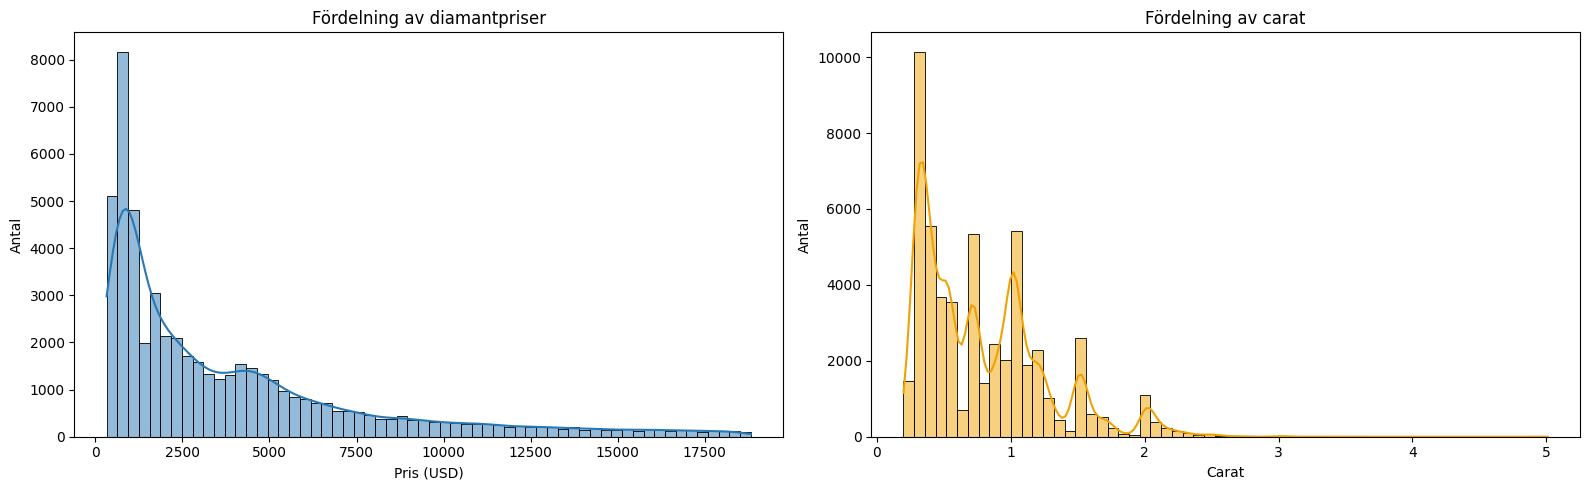

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(df["price"], bins=60, kde=True, color="#2878B5", ax=axes[0])
axes[0].set_title("Fördelning av diamantpriser")
axes[0].set_xlabel("Pris (USD)")
axes[0].set_ylabel("Antal")

sns.histplot(df["carat"], bins=60, kde=True, color="#F0A202", ax=axes[1])
axes[1].set_title("Fördelning av carat")
axes[1].set_xlabel("Carat")
axes[1].set_ylabel("Antal")
plt.tight_layout()
plt.show()


#### Vad vi ser:
Majoriteten av diamanterna kostar under 5 000 USD. Caratfördelningen visar att de flesta är små till medelstora (<1.5 ct) och endast 5% är större än 1.5 ct. Vi ser en tydlig korrelation mellan storlek och pris. Här finns även en kausalitet, större diamanter är ovanligare vilket driver upp priset på dem.

#### Indikationer:
Priskänsliga och volymstarka segment dominerar marknaden. De allra största och dyraste diamanterna är sällsynta.

#### Rekommendationer:
Fokusera sortimentet på diamanter mellan 0.3 och 1.0 ct där efterfrågan är störst. Detta är den viktigaste målgruppen för volym och omsättning.


## 4. Kvalitetsfördelning (cut, color, clarity)
Här tittar jag på fördelningen av kvalitetsparametrarna: slipning (cut), färg (color) och klarhet (clarity). Det ger en bild av vilka kvalitetsnivåer som det finns flest av och kan vägleda inköps- och lagerstrategier.

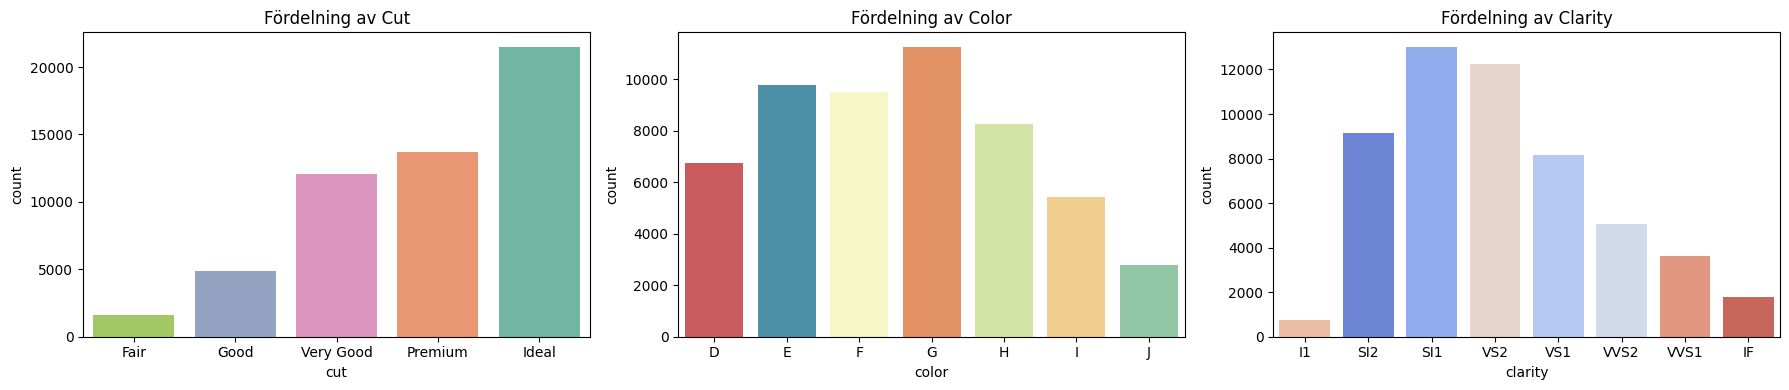

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(18, 4))
sns.countplot(x='cut', data=df, order=cut_order, hue='cut', palette="Set2", legend=False, ax=ax[0])
sns.countplot(x='color', data=df, order=color_order, hue='color', palette="Spectral_r", legend=False, ax=ax[1])
sns.countplot(x='clarity', data=df, order=clarity_order, hue='clarity', palette="coolwarm", legend=False, ax=ax[2])

for a, t in zip(ax, ["Cut", "Color", "Clarity"]): 
    a.set_title(f"Fördelning av {t}")
plt.tight_layout()
plt.show()


#### Vad vi ser:
"Ideal" och "Premium" står för över 65% av marknaden. Färg G är vanligast, och clarity VS2/SI1 dominerar.

#### Indikationer:
Efterfrågan verkar vara störts vid hög cut och tillräckligt bra färg/clarity, snarare än absolut toppkvalitet. Högsta kvalitet är ovanligt.

#### Rekommendationer:
Satsa på ett brett lager i kvaliteterna G–H och VS2–SI1. Undvik att köpa in för mycket i de dyraste och mest sällsynta segmenten där utbudet är lågt.


## 5a. Prisanalys per kvalitetsfaktor
Det här avsnittet undersöker hur olika kvalitetsfaktorer påverkar priset på diamanter. Vi tittar på relationen mellan pris och carat, men också hur priset varierar beroende på slipning, färg och klarhet.

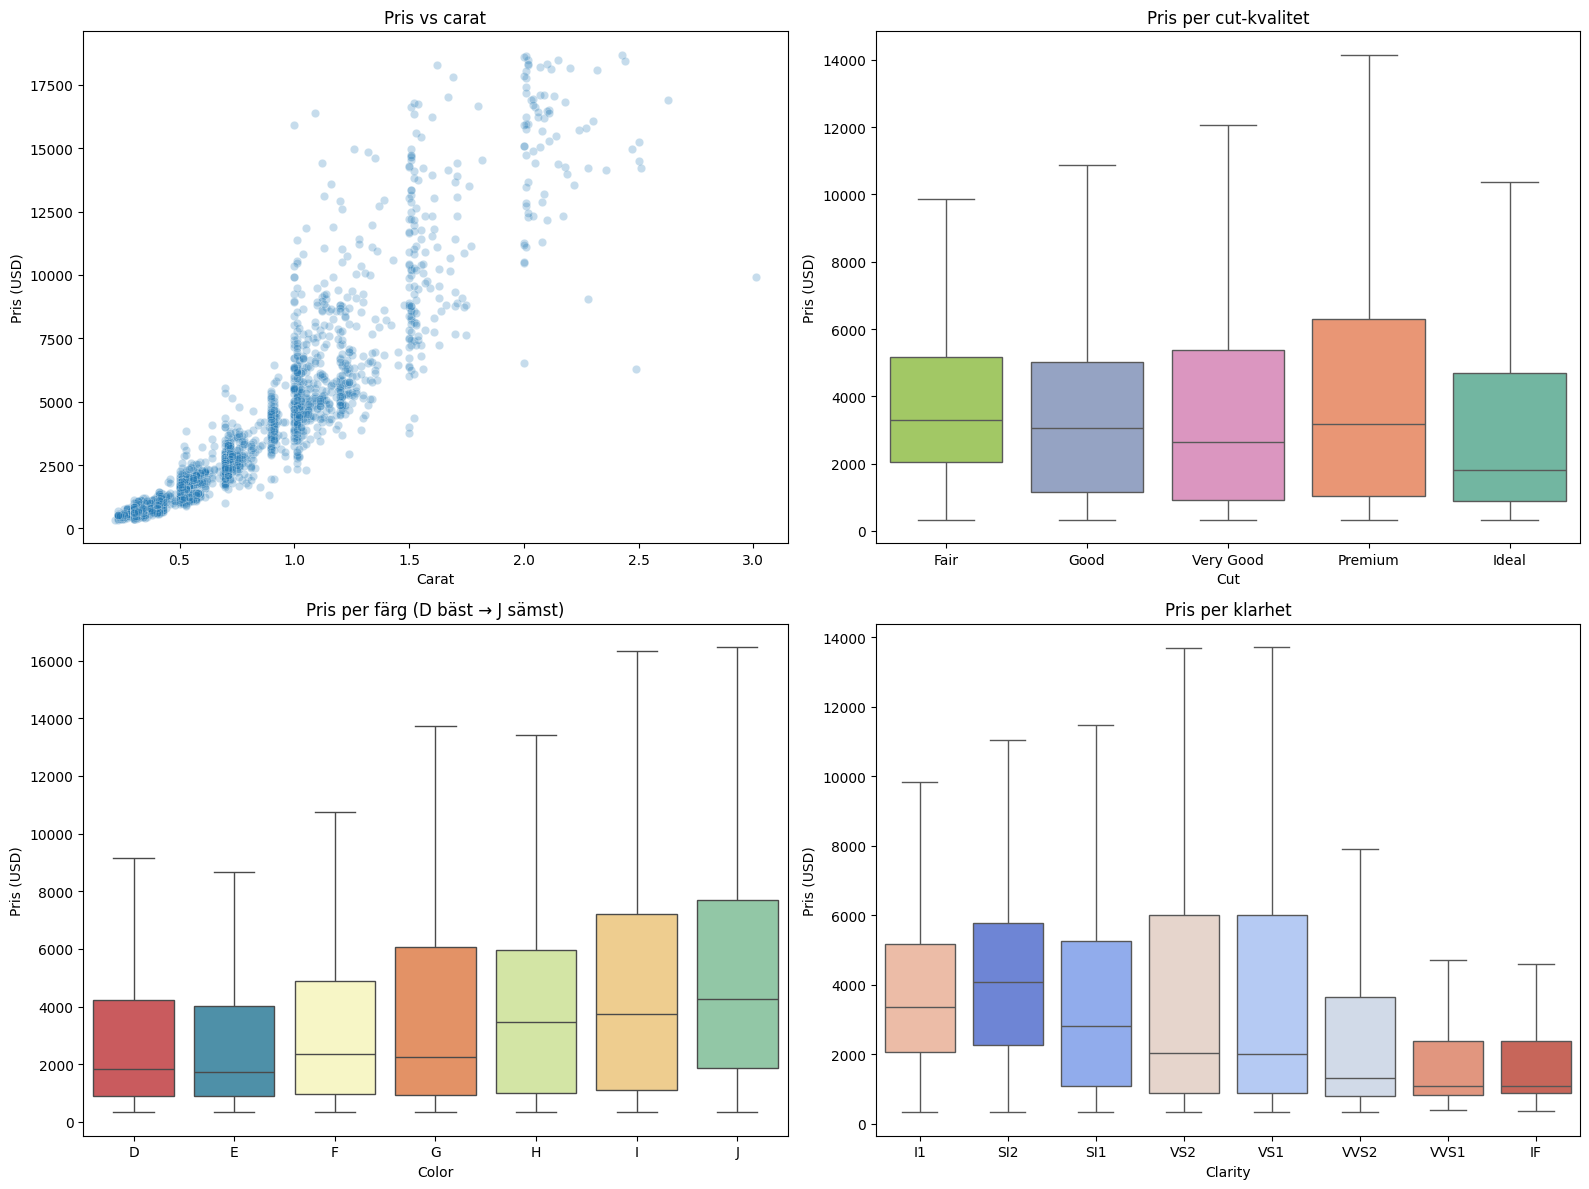

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Pris vs Carat
sns.scatterplot(x='carat', y='price', data=df.sample(2000), alpha=.25, ax=axes[0,0])
axes[0,0].set_title("Pris vs carat")
axes[0,0].set_xlabel("Carat")
axes[0,0].set_ylabel("Pris (USD)")

# Pris per Cut
sns.boxplot(x='cut', y='price', data=df, order=cut_order, hue='cut', 
            palette="Set2", legend=False, ax=axes[0,1], showfliers=False)
axes[0,1].set_title("Pris per cut-kvalitet")
axes[0,1].set_xlabel("Cut")
axes[0,1].set_ylabel("Pris (USD)")

# Pris per Color
sns.boxplot(x='color', y='price', data=df, order=color_order, hue='color', 
            palette="Spectral_r", legend=False, ax=axes[1,0], showfliers=False)
axes[1,0].set_title("Pris per färg (D bäst → J sämst)")
axes[1,0].set_xlabel("Color")
axes[1,0].set_ylabel("Pris (USD)")

# Pris per Clarity
sns.boxplot(x='clarity', y='price', data=df, order=clarity_order, hue='clarity', 
            palette="coolwarm", legend=False, ax=axes[1,1], showfliers=False)
axes[1,1].set_title("Pris per klarhet")
axes[1,1].set_xlabel("Clarity")
axes[1,1].set_ylabel("Pris (USD)")

plt.tight_layout()
plt.show()


#### Vad vi ser:
Pris och carat har ett starkt samband – större stenar kostar betydligt mer. Medianpriset verkar vara lägst i dem bästa klasserna.
#### Indikationer:
Prisdrivande faktorer i datasetet är främst storlek. Högsta cut eller färg garanterar inte högsta pris – storleken väger tyngre.

#### Rekommendationer:
Se upp för att tolka kvalitetsgrader “rakt av” – i verkligheten måste alltid storlek vägas in när prisbilden analyseras. För sälj- och inköpsbeslut: differentiera prissättningen på storlek först, sedan kvalitet.


## 5b. Varför har bättre segment lägre medianpriser? – Analys av median carat

För att förklara varför segmenten med bättre kvalitet (t.ex. högre cut, bättre färg) har lägre medianpris visar jag här att diamanterna i dessa segment också är mindre i storlek (carat).


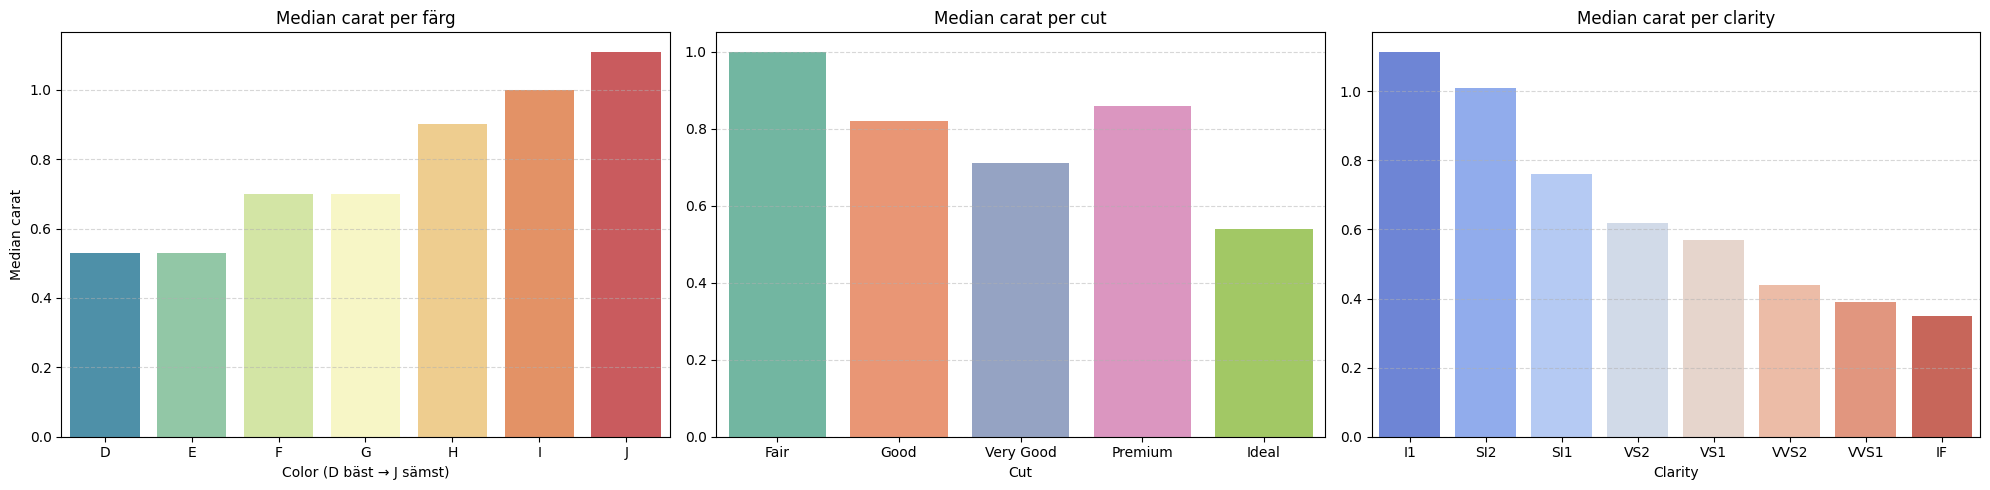

In [6]:
# Median carat per color, cut, clarity
median_carat_per_color = df.groupby('color')['carat'].median().reindex(color_order)
median_carat_per_cut = df.groupby('cut')['carat'].median().reindex(cut_order)
median_carat_per_clarity = df.groupby('clarity')['carat'].median().reindex(clarity_order)

fig, axes = plt.subplots(1, 3, figsize=(20,5))

# Color
sns.barplot(
    x=median_carat_per_color.index,
    y=median_carat_per_color.values,
    hue=median_carat_per_color.index,
    palette="Spectral_r",
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Median carat per färg")
axes[0].set_xlabel("Color (D bäst → J sämst)")
axes[0].set_ylabel("Median carat")
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Cut
sns.barplot(
    x=median_carat_per_cut.index,
    y=median_carat_per_cut.values,
    hue=median_carat_per_cut.index,
    palette="Set2",
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Median carat per cut")
axes[1].set_xlabel("Cut")
axes[1].set_ylabel("")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Clarity
sns.barplot(
    x=median_carat_per_clarity.index,
    y=median_carat_per_clarity.values,
    hue=median_carat_per_clarity.index,
    palette="coolwarm",
    legend=False,
    ax=axes[2]
)
axes[2].set_title("Median carat per clarity")
axes[2].set_xlabel("Clarity")
axes[2].set_ylabel("")
axes[2].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


#### Vad vi ser:
De bästa segmenten (D-färg, Ideal-cut, IF-clarity) har lägre medianstorlek. Större diamanter är vanligare i lägre kvaliteter.

#### Indikationer:
Detta förklarar varför segment med högsta kvalitet ofta har lägre medianpris – de består mest av mindre stenar. De största diamanterna återfinns ofta i segment med sämre färg/slipning/klarhet.

#### Rekommendationer:
Kommunicera tydligt till kunder och säljare att högsta kvalitet ofta innebär mindre stenar. Lyft fram storlekens betydelse för slutpriset, och anpassa sortiment och marknadsföring därefter.


## 6. Identifiering av prisvärda fynd
Målet här är att identifiera diamanter som kombinerar hög kvalitet med ett attraktivt pris

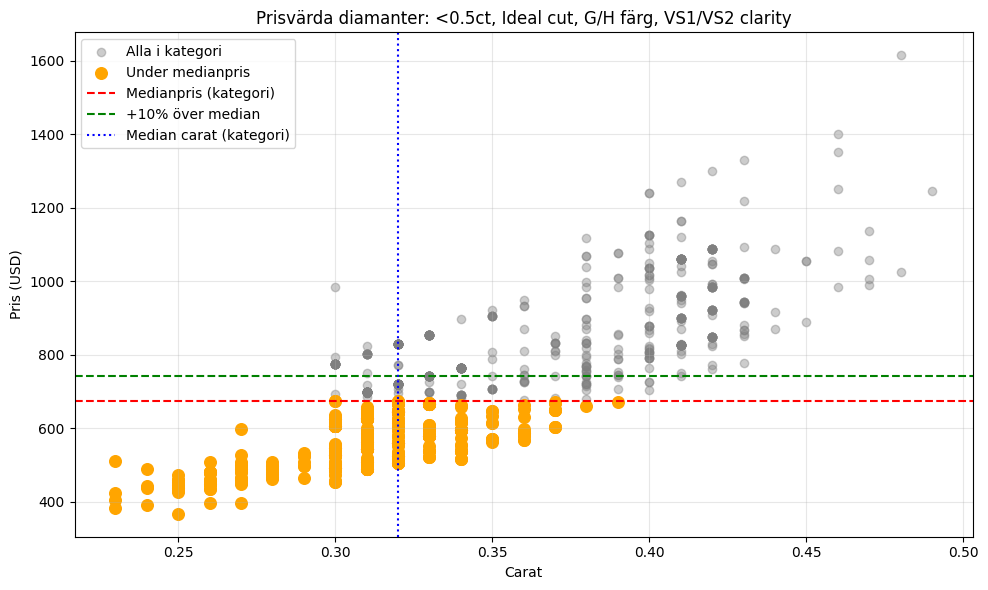

=== Hela kvalitetskategorin ===
Antal diamanter: 1025
Caratintervall: 0.23 – 0.49 ct
Prisintervall: $367.0 – $1,615.0 USD
Medianstorlek: 0.32 ct
Medianpris: $675 USD

=== Fynd under medianpris ===
Antal fynd: 509
Caratintervall: 0.23 – 0.39 ct
Prisintervall: $367.0 – $673.0 USD
Medianstorlek (fynd): 0.31 ct
Medianpris (fynd): $561 USD


In [7]:
# Filtrera fram prisvärda diamanter (hög kvalitet men <0.5ct)
prisvarda = df[
    (df['carat'] < 0.5) &
    (df['cut'] == "Ideal") &
    (df['color'].isin(["G", "H"])) &
    (df['clarity'].isin(["VS1", "VS2"]))
]

# Nyckeltal för hela kategorin
antal_kategori = len(prisvarda)
min_carat_kategori = prisvarda['carat'].min()
max_carat_kategori = prisvarda['carat'].max()
min_pris_kategori = prisvarda['price'].min()
max_pris_kategori = prisvarda['price'].max()
median_carat_kategori = prisvarda['carat'].median()
median_pris_kategori = prisvarda['price'].median()

# Hitta fynden under medianpris
prisvarda_below_median = prisvarda[prisvarda['price'] < median_pris_kategori]

# Nyckeltal för fynden (under medianpris)
antal_fynd = len(prisvarda_below_median)
min_carat_fynd = prisvarda_below_median['carat'].min()
max_carat_fynd = prisvarda_below_median['carat'].max()
min_pris_fynd = prisvarda_below_median['price'].min()
max_pris_fynd = prisvarda_below_median['price'].max()
median_carat_fynd = prisvarda_below_median['carat'].median()
median_pris_fynd = prisvarda_below_median['price'].median()

# Scatterplot: visar alla i kategorin, fynd i orange
plt.figure(figsize=(10, 6))
plt.scatter(prisvarda['carat'], prisvarda['price'], alpha=0.4, label="Alla i kategori", color='grey')
plt.scatter(prisvarda_below_median['carat'], prisvarda_below_median['price'],
            color='orange', label='Under medianpris', s=70)
plt.axhline(median_pris_kategori, color='red', linestyle='--', label='Medianpris (kategori)')
plt.axhline(median_pris_kategori * 1.10, color='green', linestyle='--', label='+10% över median')
plt.axvline(median_carat_kategori, color='blue', linestyle=':', label='Median carat (kategori)')
plt.xlabel("Carat")
plt.ylabel("Pris (USD)")
plt.title("Prisvärda diamanter: <0.5ct, Ideal cut, G/H färg, VS1/VS2 clarity")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Skriv ut alla relevanta nyckeltal
print("=== Hela kvalitetskategorin ===")
print(f"Antal diamanter: {antal_kategori}")
print(f"Caratintervall: {min_carat_kategori:.2f} – {max_carat_kategori:.2f} ct")
print(f"Prisintervall: ${min_pris_kategori:,} – ${max_pris_kategori:,} USD")
print(f"Medianstorlek: {median_carat_kategori:.2f} ct")
print(f"Medianpris: ${median_pris_kategori:,.0f} USD\n")

print("=== Fynd under medianpris ===")
print(f"Antal fynd: {antal_fynd}")
print(f"Caratintervall: {min_carat_fynd:.2f} – {max_carat_fynd:.2f} ct")
print(f"Prisintervall: ${min_pris_fynd:,} – ${max_pris_fynd:,} USD")
print(f"Medianstorlek (fynd): {median_carat_fynd:.2f} ct")
print(f"Medianpris (fynd): ${median_pris_fynd:,.0f} USD")


#### Vad vi ser:
Det finns ett brett utbud (1025 st) av små diamanter (<0.5 ct) i hög kvalitet. 509 av dessa ligger under medianpriset och utgör “prisvärda fynd”.

#### Indikationer:
Det går att köpa in många små stenar av hög kvalitet till attraktiva priser. Störst möjlighet till god marginal finns bland de diamanter som köps in under medianpriset.

#### Rekommendationer:
Satsa på “hög kvalitet till bästa pris” och rikta dig till prismedvetna kunder, t.ex. unga par.

## 7. Vinstberäkning för prisvärda fynd
Genom att simulera inköp och försäljning av de mest prisvärda diamanterna kan vi beräkna den potentiella vinsten.

In [8]:
# Beräkna försäljningsvärde och vinst
försäljningspris_median = median_pris_kategori
försäljningspris_10pct = median_pris_kategori * 1.10

tot_försäljning_median = len(prisvarda_below_median) * försäljningspris_median
tot_försäljning_10pct = len(prisvarda_below_median) * försäljningspris_10pct
tot_inköp = prisvarda_below_median['price'].sum()
potentiell_vinst_median = tot_försäljning_median - tot_inköp
potentiell_vinst_10pct = tot_försäljning_10pct - tot_inköp

print("=== VINSTBERÄKNING ===")
print(f"Antal fynd: {len(prisvarda_below_median)} diamanter")
print(f"Total inköpskostnad: ${tot_inköp:,.0f}")
print(f"\nAlternativ 1: Sälj till medianpris (${försäljningspris_median:.0f})")
print(f"Försäljningsvärde: ${tot_försäljning_median:,.0f}")
print(f"Vinst: ${potentiell_vinst_median:,.0f} (Marginal: {potentiell_vinst_median/tot_inköp:.1%})")

print(f"\nAlternativ 2: Sälj till +10% (${försäljningspris_10pct:.0f})")
print(f"Försäljningsvärde: ${tot_försäljning_10pct:,.0f}")
print(f"Vinst: ${potentiell_vinst_10pct:,.0f} (Marginal: {potentiell_vinst_10pct/tot_inköp:.1%})")


=== VINSTBERÄKNING ===
Antal fynd: 509 diamanter
Total inköpskostnad: $285,826

Alternativ 1: Sälj till medianpris ($675)
Försäljningsvärde: $343,575
Vinst: $57,749 (Marginal: 20.2%)

Alternativ 2: Sälj till +10% ($743)
Försäljningsvärde: $377,933
Vinst: $92,107 (Marginal: 32.2%)


#### Vad vi ser:
Vid försäljning till medianpris är möjlig marginal ca 20%. Vid +10% marginal ökar vinsten betydligt.

#### Indikationer:
Inköpsstrategi med fokus på fynd under medianpris skapar mycket god potential för vinst, särskilt om man kan ta ut en liten premium.

#### Rekommendationer:
Följ upp denna strategi genom att förhandla inköpspriser och prova olika prisnivåer i butik.

# Executive Summary
Analysen visar att det finns ett stort utbud av små, högkvalitativa diamanter (0,3–0,5 ct, Ideal, G–H, VS1–VS2) som kan köpas in till attraktiva priser och säljas med god marginal. Prisnivåerna styrs i första hand av storlek snarare än enbart färg eller klarhet, vilket ger Guldfynd möjlighet att erbjuda prisvärda diamanter till en bred kundgrupp. Efter omfattande datarensning har över 53 700 tillförlitliga diamanter analyserats, och mer än 500 fynd har identifierats för inköp under medianpris. För att stärka lönsamheten rekommenderas Guldfynd att fokusera inköpen mot dessa små, högkvalitativa diamanter och marknadsföra sortimentet mot prismedvetna kunder, särskilt unga par. Med denna strategi bedöms en årlig vinstpotential på 500 000–900 000 kr vara fullt möjlig.

---

# Självutvärdering
**1. Vad har varit roligast i kunskapskontrollen?**

Det roligaste har varit att arbeta med hela analyskedjan – från datarensning till att skapa visualiseringar och dra affärsmässiga slutsatser. Det har känts givande att kunna ta fram konkreta rekommendationer som faktiskt kan ha affärsnytta. Att bygga en Streamlit-app för att kunna använda sitt projekt var också både lärorikt och motiverande.

**2. Vilket betyg anser du att du ska ha och varför?**

Jag anser att jag har gjort vad som krävs för VG, eftersom jag har genomfört samtliga moment samt dokumenterat tydligt. Jag har också försökt resonera affärsmässigt och kopplat analysen till korrelationer, kausalitet och verklig affärsnytta för Guldfynd.

**3. Vad har varit mest utmanande i arbetet och hur har du hanterat det?**

Det mest utmanande har varit att strukturera och rensa datan på ett sätt som är både tillräckligt noggrant och korrekt. Jag har också lagt tid på att få grafer och visualiseringar att presentera informationen tydligt. För att hantera dessa utmaningar har jag läst på, testat olika lösningar och utvärderat mina resultat kontinuerligt, samt diskuterat med klasskompisar.